# Notebook which explains how the algorithms works and how to interpret the results

## Install all necessary libraries

In [44]:
%pip install dtw-python
%pip install matplotlib
%pip install datetime
%pip install requests
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import all the libraries

In [45]:
import numpy as np
import statistics
from typing import List
import requests as req
from pprint import pprint
from statistics import mean
from dtw import *
import itertools
from datetime import datetime
import matplotlib.pyplot as plt

## Classe qui recupère les données du site Yahoo finance depuis son api ou si les données yahoo ne sont pas accessible, passe par l'api Mboum

In [46]:

class ChartAnalysis():
    def __init__(self):
        self.charts={}
    
    
    def get_chart(self,symbol:str,timeframe:int=30)->list:
        headers = {
            'x-api-key': "mTd2MNVwEe3WFgj5PQ66Tbpq0CyeP8Q7ESjpmYZ2"
        }
        try:
            url = f"https://yfapi.net/v8/finance/chart/{symbol}?range=1mo&region=FR&interval=1d&lang=en"
            response = req.request("GET", url, headers=headers)
            
            
            
            closes = response.json()["chart"]["result"][0]["indicators"]["quote"][0]['close']
            timesamps = response.json()["chart"]["result"][0]["timestamp"]
            

            return [{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, closes)]
        
        except Exception as errorYahoo:
            try:
                headers = {
                'X-Mboum-Secret': "DPEbphxr0mBRzEp956ORDzCn1DFQMX6Xhhf1g5GVw6t6LtJlNmkwmYDGKVed"
                }
                url = f"https://mboum.com/api/v1/hi/history/?symbol={symbol}&interval=1d&diffandsplits=true"
                response = req.request("GET", url, headers=headers).json()


                result = [ {"date":datetime.fromtimestamp(int(value)),"close":response['data']['items'][value]["close"]} for value in response['data']['items']]

                return result[-timeframe:]

            except Exception as errorMboum:
                raise Exception([errorMboum,errorYahoo])
        
        
    """
    Methode pour charger le graphique d'un actif depuis l'api
    On verifie si l'actif n'a pas encore été chargé
    """
    def loading(self,list_actifs:List[str]):
        for actif in list_actifs:
            if actif not in self.charts:
               self.charts[actif]=self.get_chart(actif)
        
        """Methode qui sauvegarde les differents graphiques de comparaisons des différents actifs passés dans une liste en parametre
        Print dans la console les differentes distances en fonction de l'algorithme utilisé.
        """
    def resultats_rapports(self,list_actifs:List[str]) -> dict:
        results = {}
        
        
        if self.charts == {}:
            # On construit un dictionnaire avec tous les charts des actifs de la liste
            self.charts = {actif: self.get_chart(actif) for actif in list_actifs}
        
        
        
        # Pour chaque actif 
        for actif_reference,actif_comparaison in itertools.combinations(self.charts, 2):
       
            chart_reference = [value['close'] for value in self.charts[actif_reference]]
            chart_comparison = [value['close'] for value in self.charts[actif_comparaison]]


            results[
                f"distance rapport moyenne {actif_reference} / "
                + actif_comparaison
            ] = self.distance_point_par_point_rapport_moyenne(
                chart_reference,chart_comparison,actif_reference,actif_comparaison
            )
            

            results[
                f"dynamic time warping rapport moyenne {actif_reference} / "
                + actif_comparaison
            ] = self.dynamic_time_warping_par_rapport_moyenne(
                chart_reference,chart_comparison,actif_reference,actif_comparaison
            )
        
        return results                



    
    def distance_point_par_point_rapport_moyenne(self,chart_reference,chart_comparison,actif_reference,actif_comparaison):          
         # Adapte les amplitudes des courbes pour pouvoir les comparer
        
        ## On les ramene à 1 en faisant le rapport par rapport à leur moyenne
        rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]

        # On calcule les differentes distances entre les points des deux courbes
        distances = [
            abs(rearange_reference[i] - rearange_comparison[i])
            for i in range(len(rearange_reference))
        ]
        
        ## On commence par tracer la distance entre les deux points en pointillés
        for i in range (0,len(rearange_reference)):
            x = [i,i]
            y = [rearange_reference[i],rearange_comparison[i]]
            plt.plot(x, y,"k--")
        x = np.linspace(0, len(rearange_reference)-1, len(rearange_comparison))
        
        
        ## On trace la courbe de reference
        plt.plot(x, rearange_reference, "r",label=actif_reference)
        
        ## On trace la courbe de comparaison
        plt.plot(x, rearange_comparison,"b",label=actif_comparaison)
        
        ## On affiche la legende
        plt.legend()
        
        ## On ajoute le titre de l'axe y
        plt.ylabel("Variations des prix par rapport à la moyenne sur la periode")
        
        ## On sauvegarde le fichier
        plt.savefig(f"charts/dist_point_par_point{actif_reference}_{actif_comparaison}.png")
        
        ## On affiche la courbe en output
        plt.show()
        
        
        x = np.linspace(0, len(rearange_reference)-1, len(rearange_reference))
        plt.plot(x,distances,"g")
        plt.ylabel("Distance entre les variations des points par rapport à leur valeur moyenne")
        plt.show()
        
        return {"distance totale":round(sum(distances),2),"distance moyenne":round(mean(distances),2)}
    

    
    def dynamic_time_warping_par_rapport_moyenne(self,chart_reference,chart_comparison,actif_reference,actif_comparaison):
        # Adapte les amplitudes des courbes pour pouvoir les comparer
        
        ## On les ramene à 1 en faisant le rapport par rapport à leur moyenne
        rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]


        # OO method call chain
        warping = dtw(rearange_comparison, rearange_reference, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))

        plot = warping.plot(type="twoway")
        
        # Editing the plot and saving to file
        plot.set_xlabel(f"Dynamic Time Warping entre {actif_reference} et {actif_comparaison}")
        plot.figure.savefig(f"charts/dtw{actif_reference}_{actif_comparaison}.png")

        return {"distance totale":round(warping.distance,2),"distance moyenne":round(warping.distance/len(chart_comparison),2)}
    
    


## Initializing the class to save the charts (reduce api calls when testing)

In [47]:
chartAnalysis = ChartAnalysis()
assets = ['AAPL','AMZN']
chartAnalysis.loading(assets)


## Doing the analysis for a set of assets

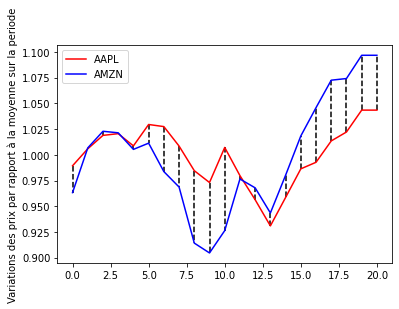

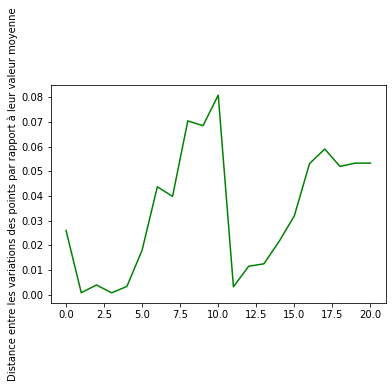

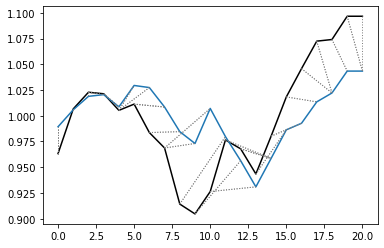

In [48]:
results = chartAnalysis.resultats_rapports(assets)

In [49]:
pprint(results)

{'distance rapport moyenne AAPL / AMZN': {'distance moyenne': 0.03,
                                          'distance totale': 0.71},
 'dynamic time warping rapport moyenne AAPL / AMZN': {'distance moyenne': 0.02,
                                                      'distance totale': 0.5}}


> On remarque que la distance recuperée avec le dynamic time warping est inférieure à celle de la distance point par point ce qui est logique puisque l'alignement est adapté.